In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime as dt
import jdatetime as jd
from loguru import logger

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from warnings import filterwarnings
filterwarnings('ignore')


In [41]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 72
plt.style.use('ggplot')
pd.options.display.float_format = '{:.0f}'.format
np.random.seed(0)
np.set_printoptions(precision=2, linewidth=100)
sns.set_context('notebook')
jd.set_locale('en')

'en'

In [3]:
revenue = pd.read_csv('data/Dataset.csv', index_col=0)

## EDA

In [4]:
def summary_statistic(df) -> pd.DataFrame:

        """
        Summary statistic of the dataset
        input: dataframe
        output: it will return a dataframe with summary statistic
        """

        feature_describe = df.describe().T.reset_index().rename(
                               columns={'index':'feature'}).drop(columns='count')

        feature_info = pd.concat([df.dtypes,
                                   df.nunique(),
                                   df.isna().sum(),
                                   df.count()], axis=1,
                    keys=['dtype', 'num_unique', 'num_Nan', 'count']).reset_index().rename(columns={'index':'feature'})

        summary_statistic_result = feature_info.merge(feature_describe, how='left', on='feature')

        return summary_statistic_result

In [146]:
summary_statistic(revenue)

,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,261960,7169337,4957141,465132,3267469,6663396,11227062,46549548
1,OrderID,int64,261960,0,261960,45264897,6121027,32930756,40061748,44792436,50045929,58853188
2,Date,int64,396,0,261960,20193661,4238,20190321,20190821,20191109,20200115,20200419
3,Revenue,int64,3314,0,261960,6110,5647,106,2451,5100,7960,175200
4,JdDate,object,396,0,261960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GDate,datetime64[ns],396,0,261960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,JdMonth,object,12,0,261960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,JdWeekday,object,7,0,261960,NaN,NaN,NaN,NaN,NaN,NaN,NaN


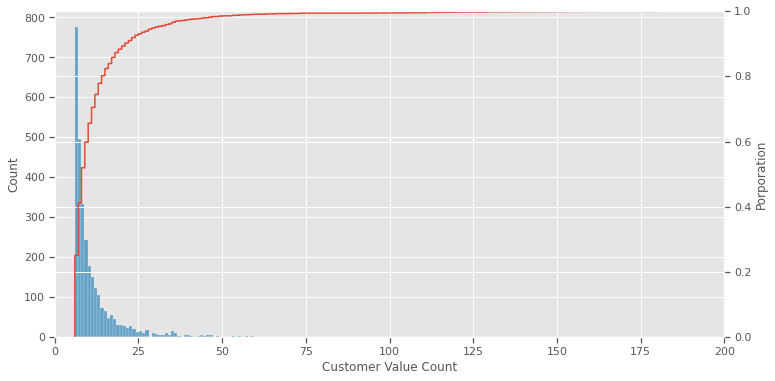

In [7]:
fig, ax1 = plt.subplots()
# ax1.set_title('Average Percipitation Percentage by Month')
ax1.set_xlabel('Customer Value Count')
ax1.set_ylabel('Count')
sns.histplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax1)
ax2 = ax1.twinx()
ax2.set_ylabel('Porporation')
sns.ecdfplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax2)
ax1.set_xlim(0,200)
ax2.set_xlim(0,200)
plt.show()

In [8]:
for index, row in revenue.iterrows():
    assert len(str(row['Date'])) == 8


### Date feature is surely in need for parsing
both to Jalali datetime and Gregory datetime

In [144]:
def convert_gregorian_persian(df,date_col,format_date):
    '''
    convert gregorian date to Jalali date
    input: dataframe, date column name, date format
    output: dataframe with Jalali date, Jalali Months, Jalali weekdays
    '''
    
    df['JdDate'] = [jd.date.fromgregorian(date=dt.datetime.strptime(str(i),str(format_date))) for i in df[date_col]]
    df['GDate'] = [dt.datetime.strptime(str(i), str(format_date)) for i in df[date_col]]
    df['GDate'] = [dt.datetime.date(i) for i in df['GDate']]
    df['GDate'] = df['GDate'].astype('datetime64')
    df['JdMonth'] = [jd.datetime.jmonth_short(i) for i in df['JdDate']]
    df['JdWeekday'] = [jd.datetime.jweekday_short(i) for i in df['JdDate']]
    
    return df

In [145]:
revenue = convert_gregorian_persian(revenue,'Date','%Y%m%d')

In [46]:
logger.info(
    f'\n last Gregory Date = {revenue.GDate.max()}, \n last Jalali date = {str(revenue.JdDate.max())}')

2022-04-10 14:19:42.895 | INFO     | __main__:<cell line: 1>:1 - 
 last Gregory Date = 2020-04-19, 
 last Jalali date = 1399-01-31


let's see if we can see the disturbution of Revenue

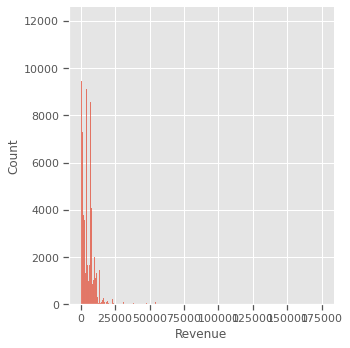

In [77]:
sns.displot(revenue.Revenue)
plt.show()

most of our variable almosst follow the pareto dist, huh! intresting.


## task 1
1. Average Order Value, Average Frequency, total revenue in each month of 1398. (Based on Persian calendar)

In [78]:
avg_order_val = np.mean(revenue.groupby('OrderID')['Revenue'].mean()) #Average Order Value
avg_freq = np.mean(revenue.groupby('CustomerID')['OrderID'].count()) #Average Frequency

logger.info(f'\n Average Order Value = {avg_order_val: .2f} \n Average Frequency = {avg_freq: .2f}')

2022-04-10 14:30:06.783 | INFO     | __main__:<cell line: 4>:4 - 
 Average Order Value =  6109.57 
 Average Frequency =  1.46


In [79]:
revehnue1398 = revenue[revenue['JdDate']< jd.date(1399, 1, 1)]
logger.info('\n AVG Revenue Per Month in 1388')
summary98 = pd.concat([revehnue1398.groupby(pd.Grouper(key="JdMonth"), as_index=False)\
                      .agg({'Revenue': 'mean','OrderID': 'count'})\
                      .rename(columns=
                                    {'Revenue': 'AVG Revenue Per Month' ,
                                    'OrderID': 'Count Order Per Month'}),
                       revehnue1398.groupby(pd.Grouper(key="JdMonth"), as_index=False)\
                                            .agg({'Revenue': 'sum'})\
                                                .rename(columns=
                                                {'Revenue': 'Total Revenue Per Month'})\
                                                                .drop(columns='JdMonth')],axis=1)

summary98

2022-04-10 14:30:10.062 | INFO     | __main__:<cell line: 2>:2 - 
 AVG Revenue Per Month in 1388


,JdMonth,AVG Revenue Per Month,Count Order Per Month,Total Revenue Per Month
0,Far,5983,3279,19618499
1,Ord,6811,3503,23860379
2,Kho,6354,14380,91363493
3,Tir,6615,16228,107350424
4,Mor,5111,28663,146502637
5,Sha,5603,18630,104375481
6,Meh,5642,26699,150623504
7,Aba,5507,33233,183010916
8,Aza,5821,30989,180390183
9,Dey,6659,26642,177407408


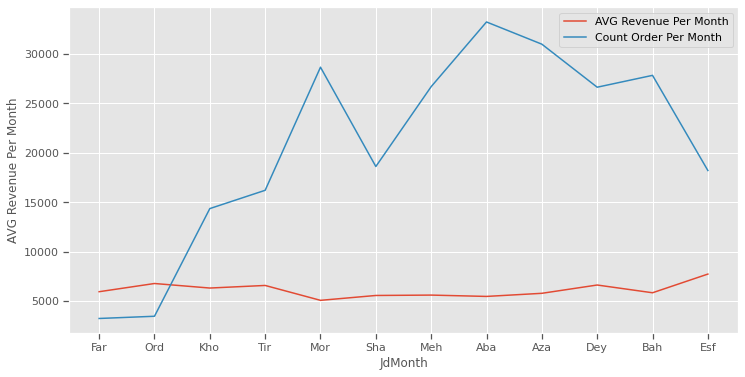

In [86]:
for ind, x in enumerate(summary98.columns[1:-1]):
    # plt.subplot(3,1,ind+1)
    sns.lineplot(data=summary98, x='JdMonth', y=x, label=x)
    # plt.tight_layout()
plt.legend()
plt.show()

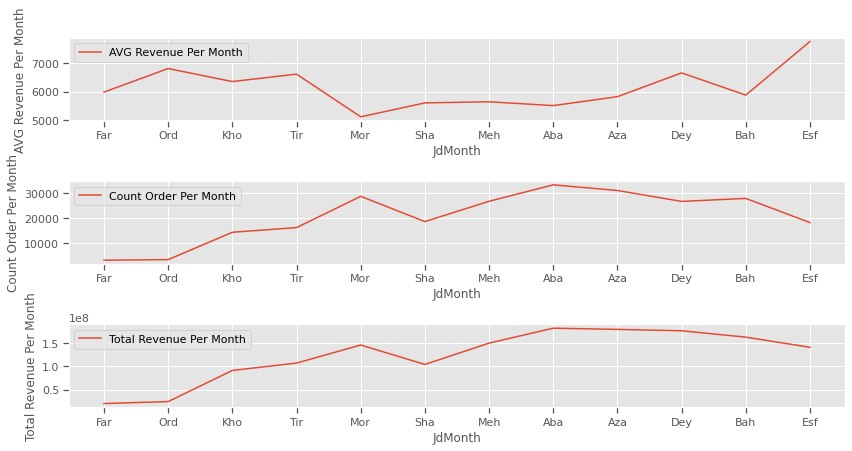

In [88]:
for ind, x in enumerate(summary98.columns[1:]):
    plt.subplot(3,1,ind+1)
    sns.lineplot(data=summary98, x='JdMonth', y=x, label=x)
    plt.tight_layout()
# plt.legend()
plt.show()

In [99]:
# style.applymap(lambda v:'color:red;' if v is True, props='color:red;')\
# .applymap(lambda v:'color:red;' if v is True else None)

pd.concat([summary98.JdMonth, 
           summary98[summary98==summary98.max(numeric_only=True)].drop(columns='JdMonth')],
           axis=1)


,JdMonth,AVG Revenue Per Month,Count Order Per Month,Total Revenue Per Month
0,Far,NaN,NaN,NaN
1,Ord,NaN,NaN,NaN
2,Kho,NaN,NaN,NaN
3,Tir,NaN,NaN,NaN
4,Mor,NaN,NaN,NaN
5,Sha,NaN,NaN,NaN
6,Meh,NaN,NaN,NaN
7,Aba,NaN,33233,183010916
8,Aza,NaN,NaN,NaN
9,Dey,NaN,NaN,NaN


In [158]:
# rev_agg = revenue.groupby(pd.Grouper(key='GDate', freq='M'))[['Revenue']]
# rev_agg_dict = dict(rev_sum = rev_agg.sum(), rev_mean = rev_agg.mean(), rev_median = rev_agg.median())
# _ = 1
# for k, v in rev_agg_dict.items():
#     # print(v)
#     # break
#     plt.subplot(3,1,_)
#     plt.title(k)
#     sns.lineplot(x=v.index, y=v.Revenue)
#     _ += 1
# plt.tight_layout()
# plt.show()


In [159]:
LASTGDATE = revenue.GDate.max()
LASTJDATE = revenue.JdDate.max()

let's creat Recency, Frequency, Monitize(both on avg and total)

In [160]:
recency = revenue.groupby(['CustomerID'],as_index=False)['JdDate'].max()\
                 .rename(columns={'JdDate': 'LastPurchaseDate'})
recency['Recency'] = recency.LastPurchaseDate.apply(lambda x:(LASTJDATE - x).days)


<AxesSubplot:xlabel='Recency', ylabel='Count'>

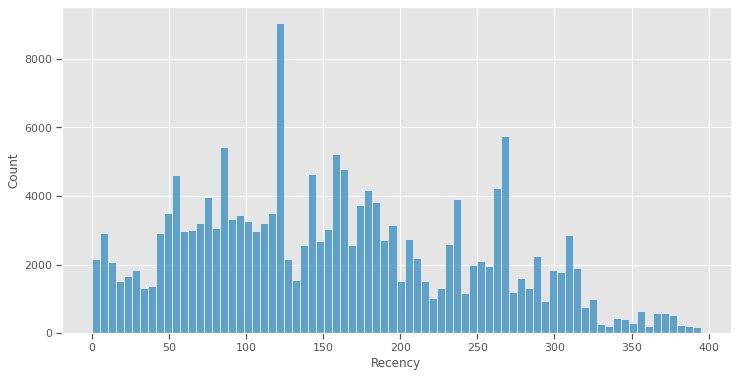

In [161]:
sns.histplot(recency.Recency)

In [162]:
freq_mon = revenue.groupby('CustomerID', as_index=False)\
                  .agg({'OrderID': 'count',
                        'Revenue': 'sum'})\
                  .rename(columns={'OrderID' :'Frequency',
                           'Revenue':'Monetary'})

<AxesSubplot:xlabel='Frequency', ylabel='count'>

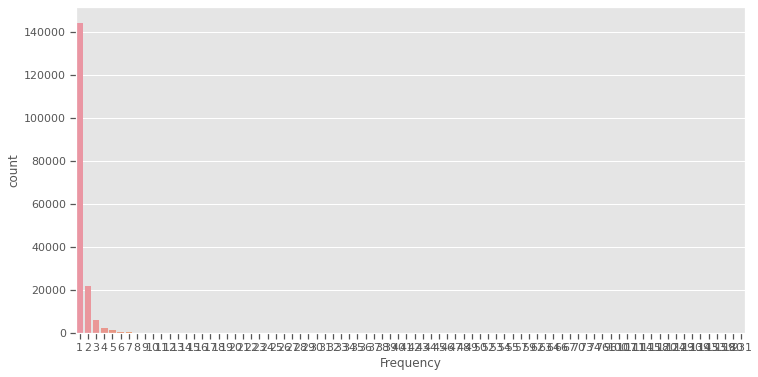

In [163]:
sns.countplot(freq_mon.Frequency)


pareto again :)

<AxesSubplot:xlabel='Monetary'>

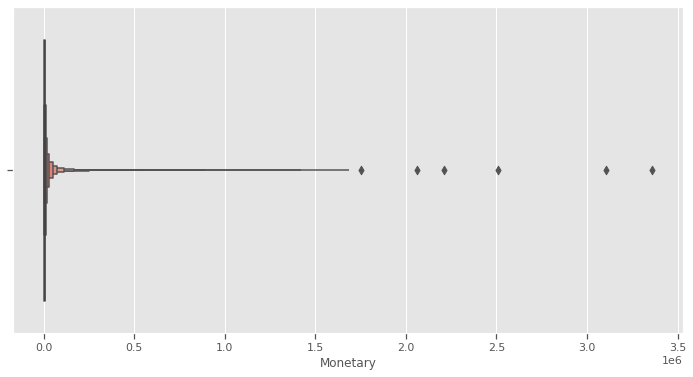

In [164]:
sns.boxenplot(freq_mon.Monetary)

In [165]:
rfm_df = recency.merge(freq_mon,on='CustomerID').drop(columns='LastPurchaseDate')

In [167]:
logger.info(f'Data shape: {rfm_df.shape}')
summary_statistic(rfm_df)

2022-04-10 15:25:08.209 | INFO     | __main__:<cell line: 1>:1 - Data shape: (179680, 4)


,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,179680,7606196,5001455,465132,3536368,7100330,11658242,46549548
1,Recency,int64,396,0,179680,158,90,0,85,150,232,395
2,Frequency,int64,82,0,179680,1,2,1,1,1,1,231
3,Monetary,int64,16962,0,179680,8907,25864,106,2899,5467,9754,3360683


2022-04-10 15:27:16.845 | INFO     | __main__:check_skew:6 - 
 Recency's: Skew: 0.32064945876314715, : SkewtestResult(statistic=54.15561530881222, pvalue=0.0) 

2022-04-10 15:27:17.977 | INFO     | __main__:check_skew:6 - 
 Frequency's: Skew: 29.710390475484978, : SkewtestResult(statistic=605.8684556035356, pvalue=0.0) 

2022-04-10 15:27:18.930 | INFO     | __main__:check_skew:6 - 
 Monetary's: Skew: 50.91426917719234, : SkewtestResult(statistic=681.9671668363789, pvalue=0.0) 



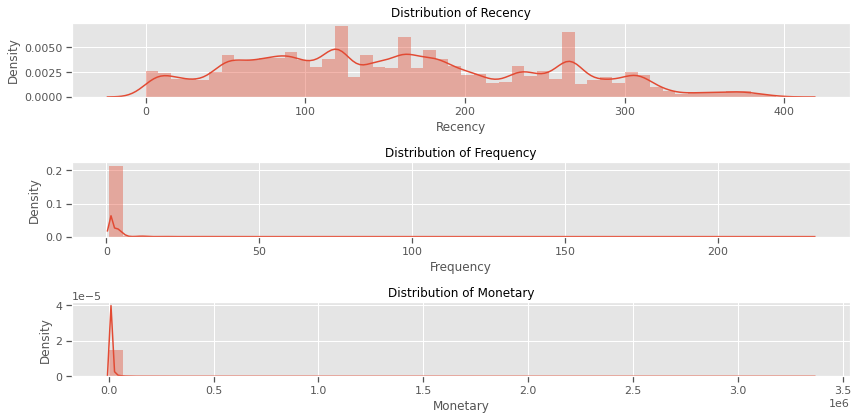

In [170]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    logger.info(f"\n {column}'s: Skew: {skew}, : {skewtest} \n")
    return


for ind, i in enumerate(rfm_df.columns[1:]):
    plt.subplot(3,1, ind+1)
    check_skew(rfm_df, i)
plt.tight_layout()
plt.show()

Obviously, we have to deal with this heavy skewness, and data has extreme outliers. I believe logarithmic scaling for Frequency and Monetary features and winsorizing and standard scaling for all, makes sense.


In [183]:
rfm_log = pd.concat([rfm_df[['CustomerID', 'Recency']], np.log(rfm_df[['Monetary', 'Frequency']])], axis=1)


In [184]:
rfm_log.head()

,CustomerID,Recency,Monetary,Frequency
0,465132,141,9,0
1,465164,51,6,0
2,465198,6,9,0
3,465204,168,7,0
4,465211,88,8,0


2022-04-10 15:43:54.558 | INFO     | __main__:check_skew:6 - 
 Recency's: Skew: 0.32064945876314715, : SkewtestResult(statistic=54.15561530881222, pvalue=0.0) 

2022-04-10 15:43:55.464 | INFO     | __main__:check_skew:6 - 
 Monetary's: Skew: -0.3747150407190465, : SkewtestResult(statistic=-62.763502952820964, pvalue=0.0) 

2022-04-10 15:43:56.269 | INFO     | __main__:check_skew:6 - 
 Frequency's: Skew: 2.955378295305225, : SkewtestResult(statistic=282.33859954303, pvalue=0.0) 



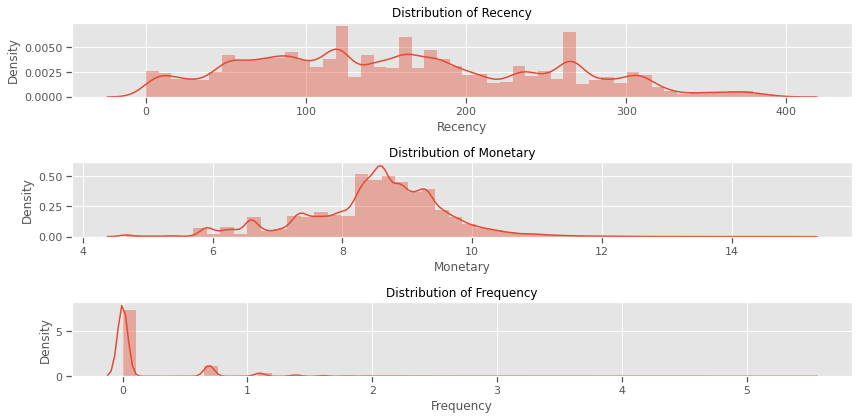

In [185]:
for ind, i in enumerate(rfm_log.columns[1:]):
    plt.subplot(3,1, ind+1)
    check_skew(rfm_log, i)
plt.tight_layout()
plt.show()

## Clustering

In [ ]:
scaler = StandardScaler()

# sns.distplot(scaler.fit_transform(rfm_df))
# check_skew(RFM_Table_scaled)